<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/DEAufficiale%20da%20commentare%20e%20aggiustare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# Carica i file manualmente
uploaded = files.upload()  # Seleziona i file file1.ann e file2.ann dalla tua scrivania

Saving file1.ann to file1.ann
Saving file2.ann to file2.ann


In [2]:
import csv
import pandas as pd

# Funzione per convertire un file .ann in .csv
def convert_ann_to_csv(input_file, output_file):
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Rimuovi spazi vuoti
            if line and '\t' in line:  # Controlla che non sia vuota e contenga tabulazioni
                parts = line.split('\t')
                if len(parts) == 4:  # Controlla che ci siano esattamente 4 colonne
                    id, start, end, label = parts
                    # Filtra token non alfanumerici o righe non valide
                    if id.isalnum() or len(id) > 1:  # Mantieni token validi
                        try:
                            # Prova a convertire start e end in interi
                            data.append([id, int(start), int(end), label])
                        except ValueError:
                            continue

    # Scrivi il file CSV
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'Start', 'End', 'Label'])  # Intestazioni
        writer.writerows(data)

# Percorsi dei file .ann
file1_ann_path = 'file1.ann'  # Sostituisci con il percorso reale
file2_ann_path = 'file2.ann'  # Sostituisci con il percorso reale

# Percorsi dei file CSV temporanei
file1_csv_path = 'file1_converted.csv'
file2_csv_path = 'file2_converted.csv'

# Conversione dei file .ann in .csv
convert_ann_to_csv(file1_ann_path, file1_csv_path)
convert_ann_to_csv(file2_ann_path, file2_csv_path)

# Caricamento dei file CSV convertiti in DataFrame
df1 = pd.read_csv(file1_csv_path)
df2 = pd.read_csv(file2_csv_path)

# Unione dei DataFrame
ds = pd.concat([df1, df2], ignore_index=True)

# Salvataggio del dataset unito come CSV
merged_dataset_path = 'merged_dataset.csv'
ds.to_csv(merged_dataset_path, index=False)

# Visualizzazione del risultato
print(f"Dataset unito salvato come '{merged_dataset_path}'")
print(ds.head())



Dataset unito salvato come 'merged_dataset.csv'
             id  Start  End                     Label
0   Ventricular      0   11  B-Multi-tissue_structure
1  fibrillation     12   24                         O
2           due     25   28                         O
3            to     29   31                         O
4          long     32   36                         O


In [3]:
!pip install pandas matplotlib

In [4]:

import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.interpolate import make_interp_spline
from collections import Counter
from scipy.interpolate import make_interp_spline

# DATA EXPLORATORY ANALYSIS (DEA)

# MISSING VALUES

Handling missing values is a critical step in any data preprocessing pipeline, as they can introduce bias or reduce the performance of subsequent analyses and models.

In [5]:
ds.isnull().sum()

,0
id,18
Start,0
End,0
Label,0


The dataset contains 18 missing values, which could negatively impact subsequent analyses and operations. To address this issue, we will simply remove these missing entries using the pandas dropna() function. This approach ensures a cleaner and more reliable dataset for further processing.

In [6]:
ds.dropna(inplace=True)

# Classification labels frequency



As the first step of the exploratory analysis, we printed all the named entity recognition (NER) tags along with their frequencies in the biomedical papers under analysis.

In [7]:
ds['Label'].unique()

array(['B-Multi-tissue_structure', 'O', 'B-Organism_substance',
       'B-Organism_subdivision', 'B-Organ', 'I-Multi-tissue_structure',
       'B-Cellular_component', 'I-Cellular_component', 'B-Cell', 'I-Cell',
       'B-Immaterial_anatomical_entity', 'B-Tissue', 'I-Tissue',
       'B-Pathological_formation', 'B-Anatomical_system',
       'I-Organism_substance', 'I-Anatomical_system',
       'I-Pathological_formation', 'I-Immaterial_anatomical_entity',
       'I-Organ', 'I-Organism_subdivision',
       'B-Developing_anatomical_structure',
       'I-Developing_anatomical_structure'], dtype=object)

In [8]:
ds['Label'].value_counts()

,count
Label,
O,91805
B-Cell,776
B-Multi-tissue_structure,639
I-Cell,442
B-Organ,381
B-Pathological_formation,367
I-Multi-tissue_structure,359
B-Organism_substance,291
I-Pathological_formation,230


In [9]:
count_O = ds['Label'].value_counts().get('O',0)
print(count_O)
O_frequency = (count_O / len(ds)) *100
print(O_frequency)

91805
95.28875695424728


In the following, we performed a mapping of the NER tags by grouping the labels of the same class, marked with either I or B, into a single representative label for each class. This was done to provide a clearer representation of the frequency with which each class appears in the text.
Hence, We represented the token distribution per class using histograms, both before and after applying the mapping.

For the purpose of creating an explanatory graphical representation of the frequency, I excluded the Outside (O) NER tags from the mapping. This decision was made because, as observed in the output of the counts, there is a clear and significant imbalance, with O accounting for 91805 occurrences, representing 95% of the total NER tags.

In [10]:
# mapping lables

mapping = {'B-Multi-tissue_structure': 'Multi-tissue_structure',
           'I-Multi-tissue_structure': 'Multi-tissue_structure',
           'B-Organism_substance':'Organism_substance',
           'I-Organism_substance':'Organism_substance',
           'B-Organism_subdivision':'Organism_subdivision',
           'I-Organism_subdivision':'Organism_subdivision',
           'B-Organ':'Organ',
           'I-Organ':'Organ',
           'B-Cellular_component':'Cellular_component',
           'I-Cellular_component':'Cellular_component',
           'B-Cell':'Cell',
           'I-Cell':'Cell',
           'B-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'I-Immaterial_anatomical_entity':'Immaterial_anatomical_entity',
           'B-Tissue':'Tissue',
           'I-Tissue':'Tissue',
           'B-Pathological_formation':'Pathological_formation',
           'I-Pathological_formation':'Pathological_formation',
           'B-Anatomical_system':'Anatomical_system',
           'I-Anatomical_system':'Anatomical_system',
           'B-Developing_anatomical_structure':'Developing_anatomical_structure',
           'I-Developing_anatomical_structure':'Developing_anatomical_structure',
           'O': 'O'

}

In [11]:
mapped_ds = ds.copy()
ds1 = ds.copy()
mapped_ds['Label'] = mapped_ds['Label'].map(mapping)
mapped_ds_without_O= mapped_ds[mapped_ds['Label'] != 'O']
ds_without_O = ds1[ds1['Label'] != 'O']

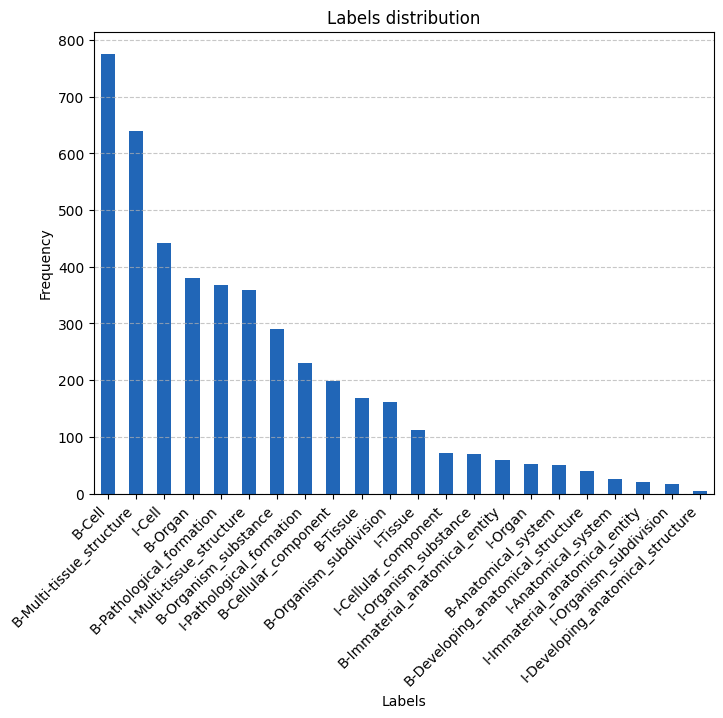

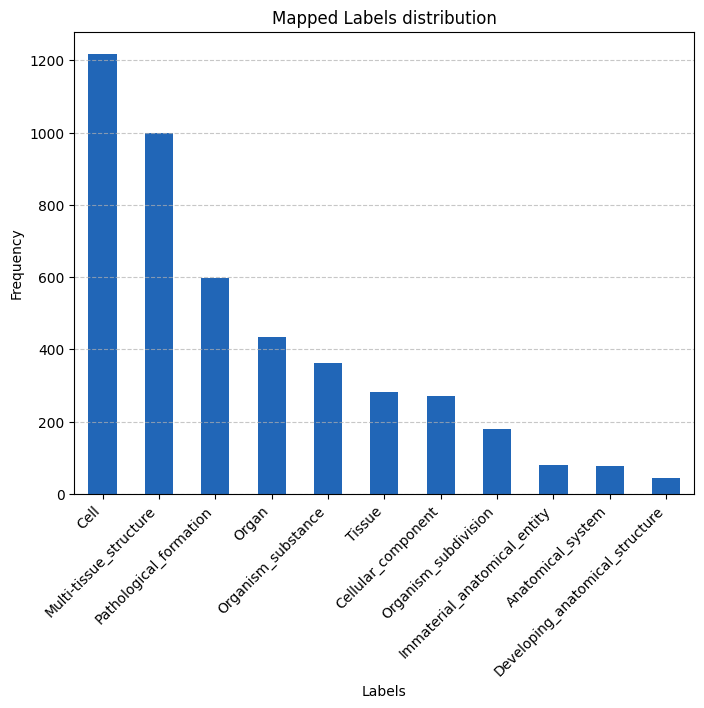

In [12]:
label_counts_mapped = mapped_ds_without_O['Label'].value_counts()
label_counts = ds_without_O['Label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color='#2166b7')
plt.title('Labels distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette per leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
label_counts_mapped.plot(kind='bar', color='#2166b7')
plt.title('Mapped Labels distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Ruota le etichette per leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Based on the histograms, before the mapping, the dataset exhibits a higher granularity with distinct "B-" and "I-" prefix labels representing token positions in entities. After the mapping, the labels are consolidated into broader categories, reducing the overall complexity and improving the class balance. This transformation helps simplify the classification task while retaining the essential distinctions needed for entity extraction.

# MOST FREQUENT TOKENS

Using the RegexpTokenizer(r'\w+') from NLTK, which employs the regular expression \w+ to extract alphanumeric sequences, we removed delimiters such as punctuation and other undesired symbols. This step was taken to focus the subsequent analysis on identifying semantic patterns and examining token frequency by class.

Following this, we leveraged spaCy to remove default stop words provided by the library. Since stop words often dominate token frequency counts, their removal aligns with the rationale behind eliminating delimiters: to ensure that the analysis emphasizes meaningful and semantically relevant tokens.

In [13]:
#delimiters
tokenizer = RegexpTokenizer(r'\w+')
ds['id'] = ds['id'].apply(lambda x: ' '.join(tokenizer.tokenize(str(x))))

In [14]:
#stopwords
nlp = spacy.load("en_core_web_sm")
print(nlp.Defaults.stop_words)

{'out', 'as', 'it', 'you', '‘ve', '‘m', 'nowhere', 'beforehand', 'onto', 'sometimes', 'say', 'few', "'m", 'via', 'against', 'anyone', 'often', 'others', 'indeed', 'whether', 'eleven', 'therefore', 'could', 'will', 'almost', 'other', 'rather', 'without', 'behind', 'beside', 'has', 'below', 'hereby', "'ve", 'hundred', 'across', 'to', 'seem', "n't", 'do', 'we', 'for', 'bottom', 'name', 'whence', 'here', 'moreover', 'your', 'him', 'whither', 'though', 'least', 'whereupon', 'noone', 'his', 'various', 'just', 'none', 'than', 'anything', 'all', 'same', 'himself', 'through', 'also', 'among', 'then', '‘re', 'once', 'on', 'another', 'everyone', 'throughout', 'with', 'please', 'make', 'although', 'get', 'twelve', '’d', 'more', 'itself', 'up', 'call', 'third', 'am', 'her', 'yourselves', 'yet', 'each', 'much', 'while', 'seems', 'already', 'there', 'above', 'show', 'amount', 'meanwhile', 'anywhere', 'formerly', 'wherever', 'where', 'done', '‘d', 'thence', 'off', 'between', 'most', '’ve', 'have', 'ou

In [15]:
def remove_stop_words(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

ds['id'] = ds['id'].apply(remove_stop_words)

In [16]:
most_common_tokens = ds['id'].value_counts().head(10)
print(most_common_tokens)

id
            35287
1             551
0             499
5             404
2             400
patients      323
3             301
4             236
cells         236
6             195
Name: count, dtype: int64


Following, we represented the most frequent tokens for each label individually. This step helps to identify distinctive terms associated with specific labels, providing insights into the linguistic patterns that could be useful for model training and improving classification performance.

In [17]:

# Conta i token più frequenti per ciascuna classe
most_common_tokens_per_class = (
    ds.groupby('Label')['id']
    .value_counts()  # Conta i token per classe
    .groupby(level=0)  # Raggruppa di nuovo per classe
    .head(5)  # Prendi i primi 5 token per classe
)

# Trasforma in DataFrame con tutte le informazioni necessarie
most_common_tokens = most_common_tokens_per_class.reset_index(name='Frequency')

# Verifica che il risultato sia un DataFrame
print(type(most_common_tokens))  # Dovrebbe essere <class 'pandas.core.frame.DataFrame'>
print(most_common_tokens.head())  # Verifica la struttura


<class 'pandas.core.frame.DataFrame'>
                 Label             id  Frequency
0  B-Anatomical_system    respiratory          9
1  B-Anatomical_system  corticospinal          7
2  B-Anatomical_system   neurological          7
3  B-Anatomical_system        central          5
4  B-Anatomical_system       skeletal          5


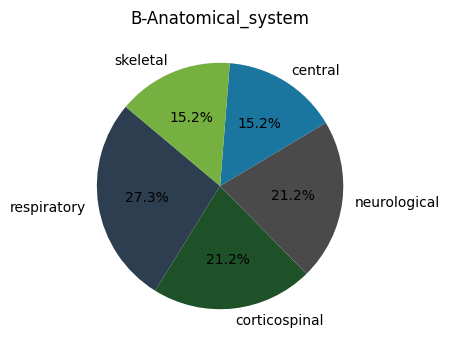

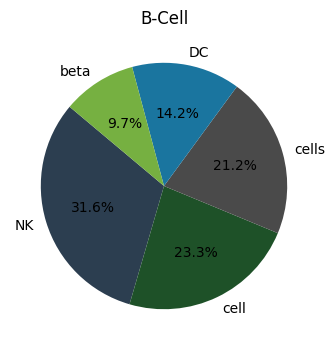

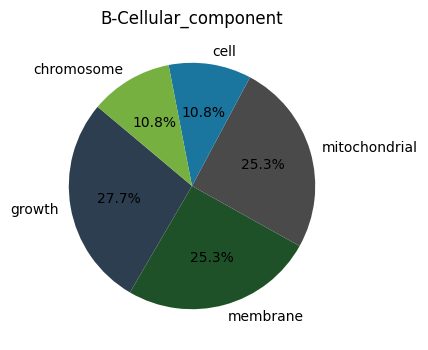

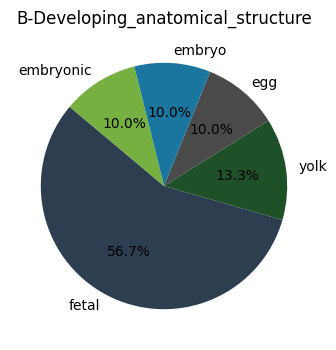

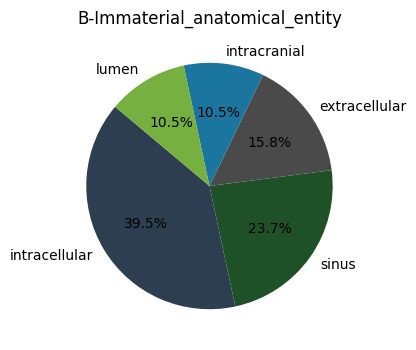

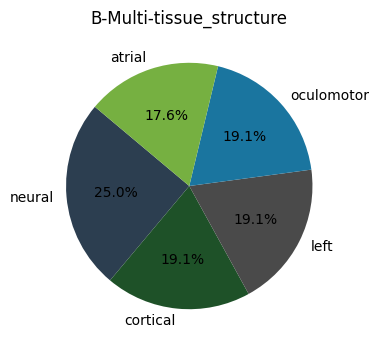

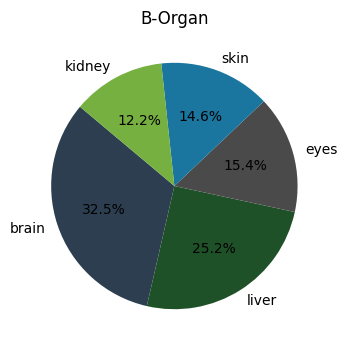

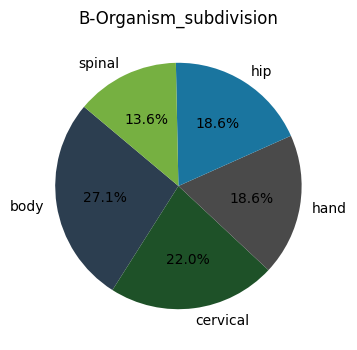

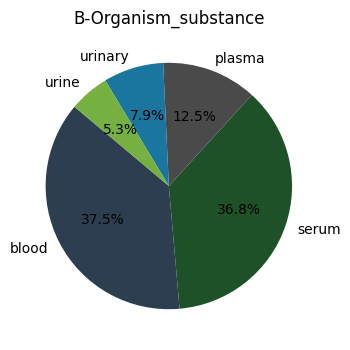

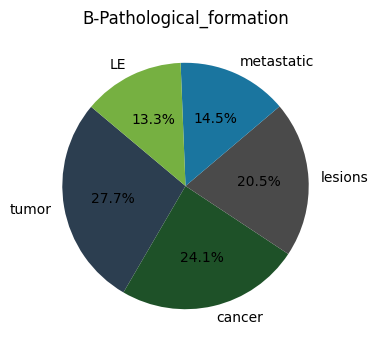

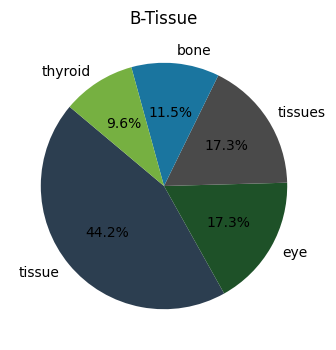

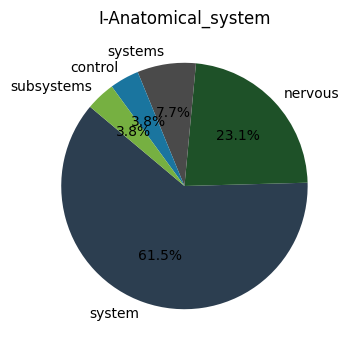

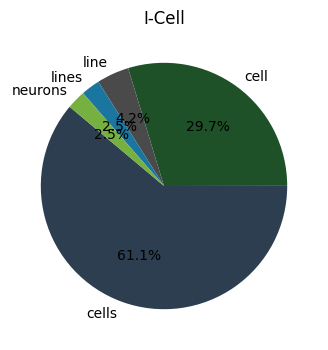

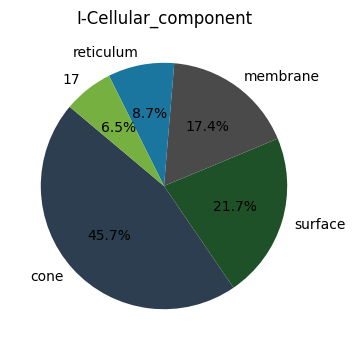

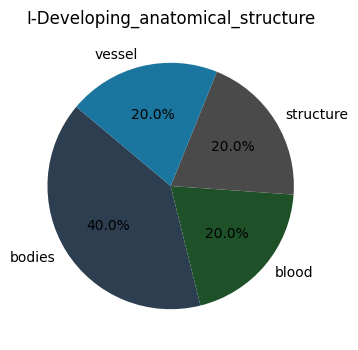

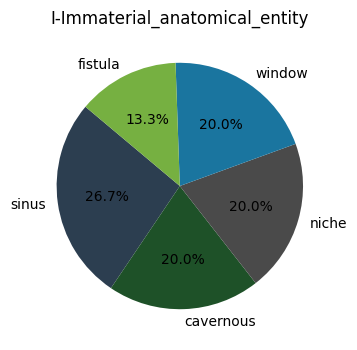

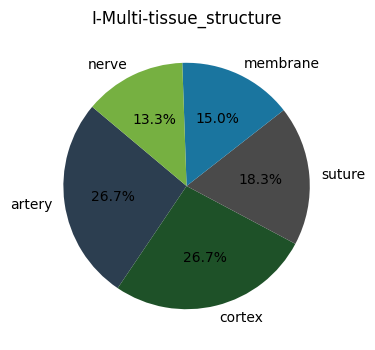

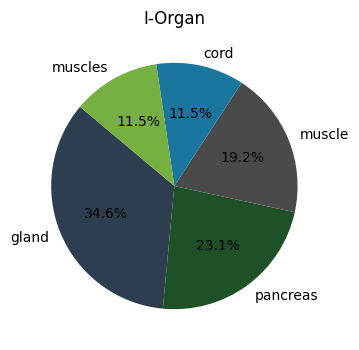

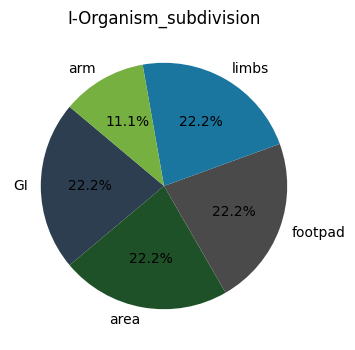

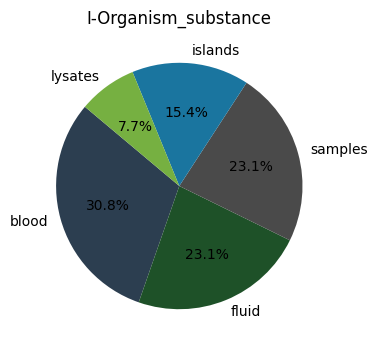

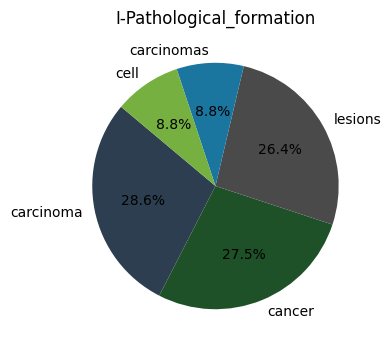

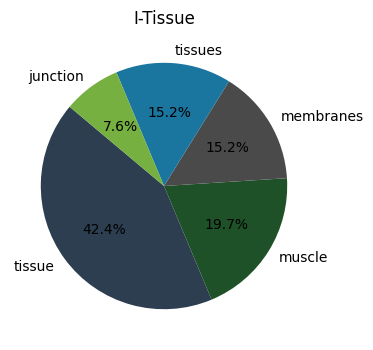

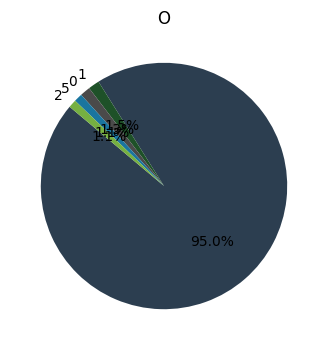

In [18]:
import matplotlib.pyplot as plt


for label in most_common_tokens['Label'].unique():
    class_tokens = most_common_tokens[most_common_tokens['Label'] == label]
    plt.figure(figsize=(4, 4))
    plt.pie(
        class_tokens['Frequency'],
        labels=class_tokens['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors = ['#2C3E50', '#1E5128', '#4A4A4A', '#1A759F', '#76B041',
                          '#3C3C3C', '#1F4E5F', '#9DA5B0', '#2B9348', '#5C5C5C']
    )
    plt.title(label)
    plt.show()




Ecco una lista ordinata di step per completare la tua Data Exploratory Analysis (DEA):

1. Analisi delle distribuzioni statistiche
Calcola e rappresenta graficamente:
La distribuzione della lunghezza delle frasi.
La distribuzione della lunghezza dei token.


2. Analisi linguistica del corpus
POS tagging: Analizza e visualizza la distribuzione delle Part-of-Speech (POS) nei dati per comprendere la struttura linguistica delle frasi.
Dependency parsing: Studia le relazioni grammaticali tra i token (es. soggetto-verbo-oggetto) e verifica se alcune strutture sintattiche sono associate a determinate classi.
Analisi dei lemmi: Analizza i lemmi più frequenti per verificare se ci sono variazioni significative rispetto ai token.
3. Word Cloud per le classi
Crea una Word Cloud per ogni classe per visualizzare rapidamente i termini più rappresentativi (già hai analizzato i token frequenti, ma la Word Cloud aggiunge una componente visiva utile).

5. Riduzione dimensionale del testo
Utilizza LDA (Latent Dirichlet Allocation)

6. Report finale DEA. fare una dashbord
Organizza i risultati in un report visivo e descrittivo, includendo:
Grafici di distribuzione e tabelle riassuntive.
Le principali intuizioni derivate da ciascun passo.
Considerazioni sui pattern osservati e il loro impatto sull’implementazione dei modelli successivi.


DISTRIBUZIONE DELLA LUNGHEZZA DEI TOKEN

In [19]:

import seaborn as sns

ds['token_length'] = ds['id'].apply(len)
token_stats = ds.groupby('Label')['token_length'].agg(['mean', 'median', 'std', 'min', 'max', ]).reset_index()
print(token_stats)


                                Label       mean  median       std  min  max
0                 B-Anatomical_system  10.000000    11.0  3.000000    3   15
1                              B-Cell   5.226804     4.0  3.181414    0   16
2                B-Cellular_component   8.713568     8.0  3.090122    1   15
3   B-Developing_anatomical_structure   5.615385     5.0  2.059834    3   14
4      B-Immaterial_anatomical_entity   9.450000    11.5  4.106320    4   17
5            B-Multi-tissue_structure   7.248826     7.0  2.591110    2   18
6                             B-Organ   5.776903     5.0  1.820957    2   12
7              B-Organism_subdivision   5.567901     5.0  2.589699    0   16
8                B-Organism_substance   5.790378     5.0  2.069660    0   14
9            B-Pathological_formation   7.092643     6.0  3.391105    2   19
10                           B-Tissue   7.130178     7.0  2.669421    2   15
11                I-Anatomical_system   6.500000     6.0  0.860233    6   10

ho usato come treshold 45 perchè la prola più lunga del vocabolario inglese contiene 45 caratteri, tra l'altro di origine medica Pneumonoultramicroscopicsilicovolcanoconiosis.

prossimi step:
controllare di che tipo sono sti 78 token problematici.
I token anomali con lunghezze elevate come quelli riportati sembrano essere sequenze alfanumeriche, che non rappresentano né numeri puri né parole convenzionali. Potrebbero derivare da:

Codici o hash:
Token generati automaticamente (es. hash, identificatori univoci).
Errori di annotazione:
Dati che non sono stati correttamente processati o annotati nel file originale.
MathType o LaTeX:
Se i dati provengono da documenti scientifici, questi token potrebbero essere frammenti di formule matematiche o di markup (es. MathType, LaTeX).
Rumore nei dati:
Dati che non hanno rilevanza per l'analisi.

capire come gestirli , 2. Azioni correttive
Escludere i token anomali: Rimuovi i token con lunghezza superiore a una soglia.
Troncare: Se i token contengono informazioni utili, considera di troncarli a una lunghezza ragionevole.
Classificare come "altro": Puoi mappare questi token a una categoria generica o speciale.

*La presenza di questi token può influenzare negativamente le analisi statistiche e i modelli di NLP.*

In [20]:
print(ds[ds['token_length'] > 45])  # Check tokens longer than 45 characters

                                                      id  Start    End Label  \
52372  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    545    630     O   
52378  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...    723    840     O   
52388  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    883    968     O   
52394  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...   1061   1178     O   
52687  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...   2887   2972     O   
...                                                  ...    ...    ...   ...   
53918  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...  18939  19022     O   
53919  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...  19023  19114     O   
53951  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...  19263  19348     O   
53957  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...  19441  19943     O   
53960  f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...  19960  20071     O   

       token_length  
52372            

In [21]:
over_length=ds[ds['token_length']>45]
import re

# Funzione per identificare potenziali hash (MD5, SHA1, SHA256, UUID)
def is_hash(token):
    # MD5: 32 alfanumerici
    # SHA1: 40 alfanumerici
    # SHA256: 64 alfanumerici
    hash_pattern = re.compile(r'^[a-fA-F0-9]{32}$|^[a-fA-F0-9]{40}$|^[a-fA-F0-9]{64}$|^[0-9a-fA-F-]{36}$')
    return bool(hash_pattern.match(token))

# Aggiungi una colonna per verificare se è un hash
over_length['is_hash'] = over_length['id'].apply(is_hash)

# Mostra i token che sono identificati come hash
print(over_length[over_length['is_hash'] == True]['id'])
# Funzione per controllare se un token contiene simboli o caratteri strani
def has_special_characters(token):
    return bool(re.search(r'[^a-zA-Z0-9]', token))

# Aggiungi una colonna per identificare i token con caratteri speciali
over_length['has_special_chars'] = over_length['id'].apply(has_special_characters)

# Mostra i token con caratteri speciali
print(over_length[over_length['has_special_chars'] == True]['id'])
# Funzione per identificare LaTeX o MathType
def is_latex_math(token):
    latex_pattern = re.compile(r'\\[a-zA-Z]+|\{.*\}|\^|\_')
    return bool(latex_pattern.search(token))

# Aggiungi una colonna per identificare i token LaTeX/MathType
over_length['is_latex_math'] = over_length['id'].apply(is_latex_math)

# Mostra i token che sono identificati come LaTeX o MathType
print(over_length[over_length['is_latex_math'] == True]['id'])
# Funzione per identificare sequenze alfanumeriche casuali (rumore)
def is_random_sequence(token):
    # Se il token ha solo numeri e lettere, ma è troppo lungo per essere una parola comune
    return bool(re.match(r'^[a-zA-Z0-9]{45,}$', token))

# Aggiungi una colonna per identificare le sequenze casuali
over_length['is_random'] = over_length['id'].apply(is_random_sequence)

# Mostra i token che sembrano sequenze casuali
print(over_length[over_length['is_random'] == True]['id'])


Series([], Name: id, dtype: object)
Series([], Name: id, dtype: object)
Series([], Name: id, dtype: object)
52372    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
52378    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
52388    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
52394    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
52687    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
                               ...                        
53918    f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...
53919    f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...
53951    feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...
53957    vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...
53960    f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...
Name: id, Length: 78, dtype: object


<ipython-input-21-c7f918743f1d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_length['is_hash'] = over_length['id'].apply(is_hash)
<ipython-input-21-c7f918743f1d>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_length['has_special_chars'] = over_length['id'].apply(has_special_characters)
<ipython-input-21-c7f918743f1d>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [22]:
print(over_length.head(78))

                                                      id  Start    End Label  \
52372  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    545    630     O   
52378  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...    723    840     O   
52388  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...    883    968     O   
52394  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...   1061   1178     O   
52687  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...   2887   2972     O   
...                                                  ...    ...    ...   ...   
53918  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIafmiuaaLbaGa...  18939  19022     O   
53919  f8aYzaalaGaei4oaSJaemOEaONaeiykaKIaeiOla4IaaCz...  19023  19114     O   
53951  feaafiart1ev1aaatCvAUfKttLearuWrP9MDH5MBPbIqV9...  19263  19348     O   
53957  vr0dc8meaabaqaciaacaGaaeqabaqabeGadaaakeaacuWG...  19441  19943     O   
53960  f8aYnaaBaaaleaacqWGnbqtcqWGbbqqcqWGybawaeqaaOG...  19960  20071     O   

       token_length  is_hash  has_speci

elimina le 78 righe

In [23]:
# Exclude rows where tokens are identified as random
ds_cleaned = ds[~ds['id'].isin(over_length[over_length['is_random'] == True]['id'])]

# Reset index for the cleaned dataset
ds_cleaned.reset_index(drop=True, inplace=True)

# Check the size of the cleaned dataset
print(f"Original dataset size: {len(ds)}")
print(f"Cleaned dataset size: {len(ds_cleaned)}")

# Sample rows from the cleaned dataset
print(ds_cleaned.sample(10))

# Check if any over-length tokens remain
print(ds_cleaned[ds_cleaned['token_length'] > 45])

ds_cleaned.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")


Original dataset size: 96344
Cleaned dataset size: 96266
             id  Start   End Label  token_length
58365              244   246     O             0
73782              272   274     O             0
6241               364   367     O             0
25761         6    467   468     O             1
79939       299    684   687     O             3
24639       ODN    873   876     O             3
43317  reported    139   147     O             8
89038             1536  1539     O             0
64144      SLAP    555   559     O             4
92380             1292  1295     O             0
Empty DataFrame
Columns: [id, Start, End, Label, token_length]
Index: []
Cleaned dataset saved as 'cleaned_dataset.csv'


<Figure size 1200x800 with 0 Axes>

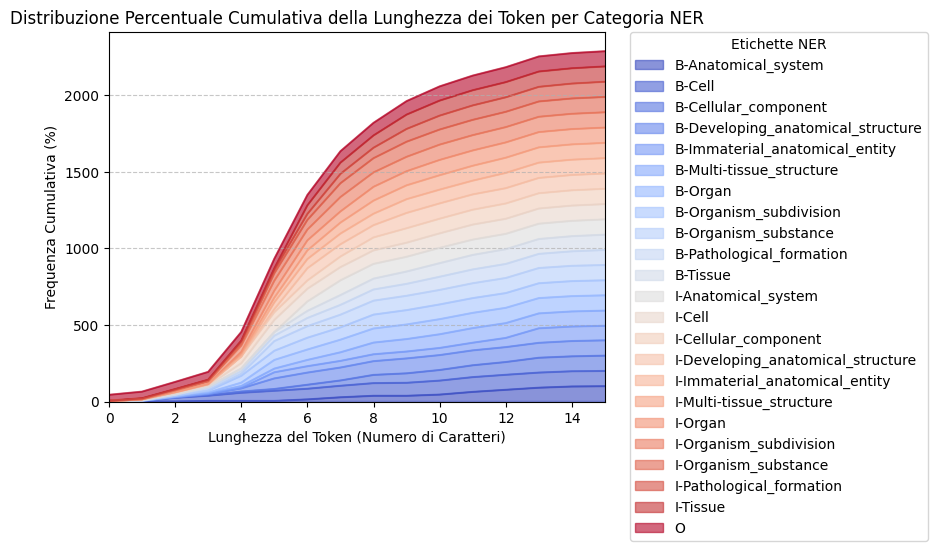

In [24]:
# Calcolo della distribuzione delle lunghezze dei token per ciascuna categoria NER
token_length_distribution = ds_cleaned.groupby(['token_length', 'Label']).size().unstack(fill_value=0)

# Calcolo della distribuzione cumulativa per ogni categoria in percentuale
token_length_distribution_cumsum = token_length_distribution.cumsum()
token_length_distribution_percent = (token_length_distribution_cumsum / token_length_distribution_cumsum.max()) * 100

# Creazione del grafico ad area per rappresentare la distribuzione cumulativa
plt.figure(figsize=(12, 8))
token_length_distribution_percent.plot(kind='area', stacked=True, alpha=0.6, colormap="coolwarm")

plt.title("Distribuzione Percentuale Cumulativa della Lunghezza dei Token per Categoria NER")
plt.xlabel("Lunghezza del Token (Numero di Caratteri)")
plt.ylabel("Frequenza Cumulativa (%)")
plt.legend(title="Etichette NER",  bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.) #bbox per spostare la legenda a sinistra
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 15)  # Limitiamo a 15 caratteri per visualizzare la maggior parte dei token

plt.show()


DISTRIBUZIONE LUNGHEZZA FRASI

<ipython-input-25-7f6cc450fd47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['Sentence_ID'] = (ds_cleaned['Start'] > ds_cleaned['End'].shift(fill_value=0)).cumsum()


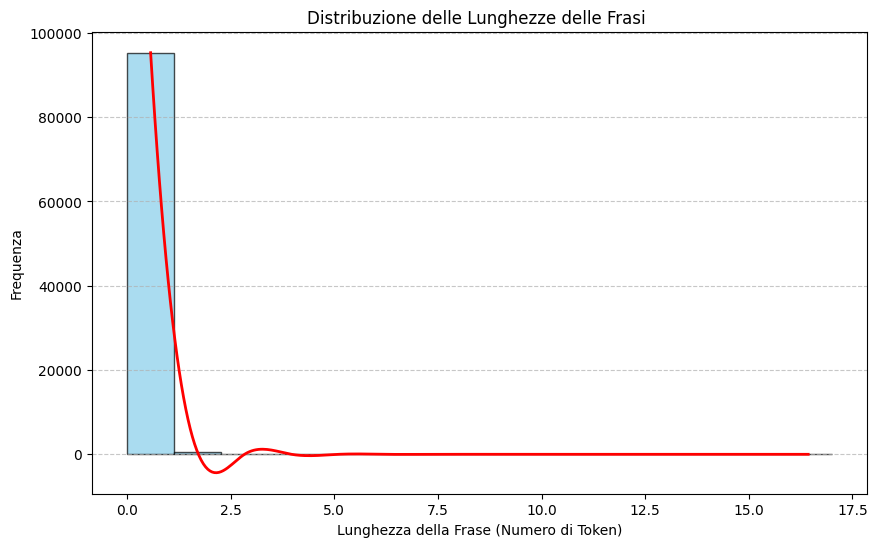

In [25]:
ds_cleaned['Sentence_ID'] = (ds_cleaned['Start'] > ds_cleaned['End'].shift(fill_value=0)).cumsum()

# Conta il numero di token per ciascuna frase
sentence_lengths = ds_cleaned.groupby('Sentence_ID').size()

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=15, range=(0, 17), color='skyblue', edgecolor='black', alpha=0.7)

# curva smussata
bin_counts, bin_edges = np.histogram(sentence_lengths, bins=15, range=(0, 17))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
xnew = np.linspace(bin_centers.min(), bin_centers.max(), 300)
spline = make_interp_spline(bin_centers, bin_counts, k=3)
y_smooth = spline(xnew)

# Aggiunta della curva interpolata
plt.plot(xnew, y_smooth, color='red', linewidth=2)

# Personalizzazione del grafico
plt.title("Distribuzione delle Lunghezze delle Frasi ")
plt.xlabel("Lunghezza della Frase (Numero di Token)")
plt.ylabel("Frequenza")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


POS

In [27]:

# Carica il modello spaCy
nlp = spacy.load('en_core_web_sm')

# Esegui il POS tagging sul dataset
def pos_tagging(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]


# Unisci i token per creare frasi
if 'Sentence_ID' in ds_cleaned.columns:
    ds_cleaned['sentence'] = ds_cleaned.groupby('Sentence_ID')['id'].transform(lambda x: ' '.join(x))

# Rimuovi duplicati e tieni solo le frasi uniche
unique_sentences = ds_cleaned[['sentence']].drop_duplicates().dropna()

# Applica il POS tagging a ciascuna frase
unique_sentences['POS'] = unique_sentences['sentence'].apply(pos_tagging)

# Conteggia le occorrenze delle POS
pos_counts = Counter([pos for pos_list in unique_sentences['POS'] for pos in pos_list])


<ipython-input-27-a15d12e8041e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cleaned['sentence'] = ds_cleaned.groupby('Sentence_ID')['id'].transform(lambda x: ' '.join(x))


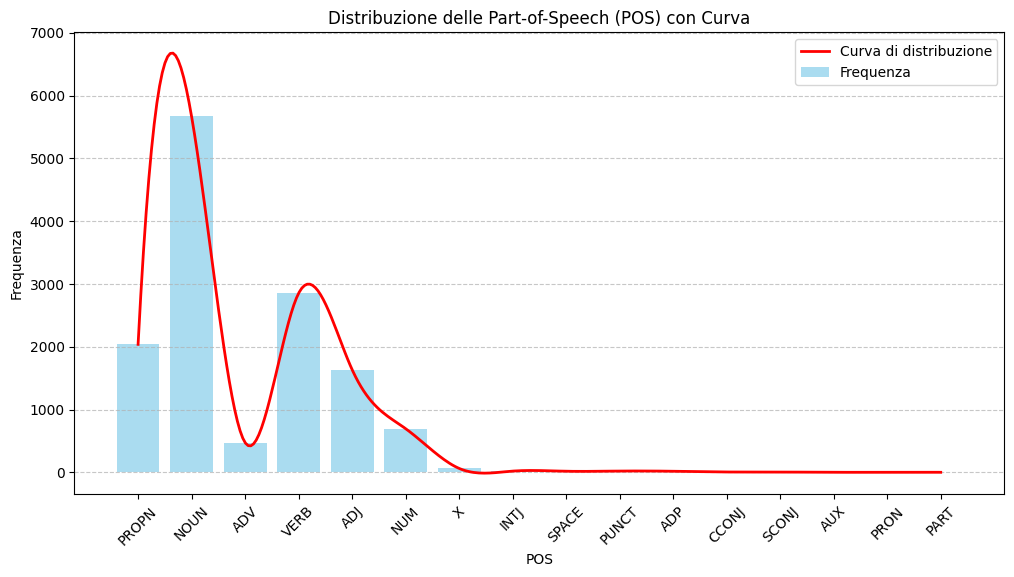

In [28]:
from scipy.interpolate import make_interp_spline


plt.figure(figsize=(12, 6))

# Grafico a barre
plt.bar(pos_counts.keys(), pos_counts.values(), color='skyblue', alpha=0.7, label="Frequenza")

# Interpolazione spline per la curva
x_pos = np.arange(len(pos_counts.keys()))  # Posizioni delle POS sull'asse X
y_pos = np.array(list(pos_counts.values()))  # Frequenze delle POS
x_smooth = np.linspace(x_pos.min(), x_pos.max(), 300)
spline = make_interp_spline(x_pos, y_pos, k=3)  # Interpolazione spline
y_smooth = spline(x_smooth)

# Aggiunta della curva interpolata
plt.plot(x_smooth, y_smooth, color='red', linewidth=2, label="Curva di distribuzione")

# Personalizzazione del grafico
plt.title("Distribuzione delle Part-of-Speech (POS) con Curva")
plt.xlabel("POS")
plt.ylabel("Frequenza")
plt.xticks(ticks=x_pos, labels=pos_counts.keys(), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()

Dependency parsing

0      [(Ventricular, ROOT, Ventricular)]
1    [(fibrillation, ROOT, fibrillation)]
2                                      []
4                    [(long, ROOT, long)]
5                        [(QT, ROOT, QT)]
Name: Dependencies, dtype: object


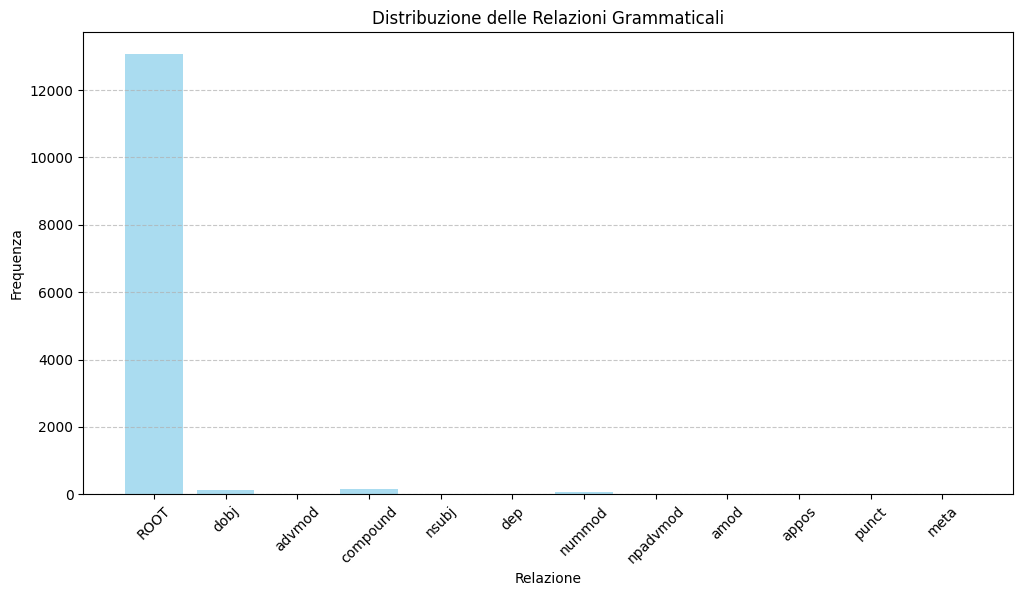

In [29]:
# Funzione per estrarre relazioni di dipendenza
def extract_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

# Applica l'analisi delle dipendenze a ciascuna frase
unique_sentences['Dependencies'] = unique_sentences['sentence'].apply(extract_dependencies)

# Visualizza un esempio
print(unique_sentences['Dependencies'].head())

# Conta la frequenza delle relazioni grammaticali
dependency_counts = Counter([dep[1] for dep_list in unique_sentences['Dependencies'] for dep in dep_list])

# Grafico delle dipendenze più frequenti
plt.figure(figsize=(12, 6))
plt.bar(dependency_counts.keys(), dependency_counts.values(), color='skyblue', alpha=0.7)
plt.title("Distribuzione delle Relazioni Grammaticali")
plt.xlabel("Relazione")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


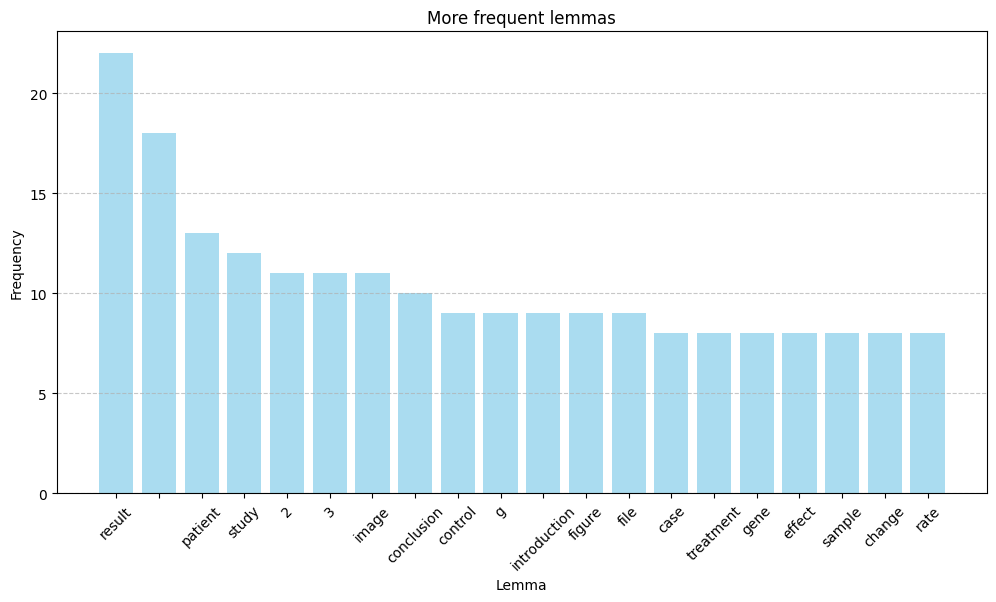

In [30]:
# Funzione per estrarre i lemmi
def extract_lemmas(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# Applica l'estrazione dei lemmi a ciascuna frase
unique_sentences['Lemmas'] = unique_sentences['sentence'].apply(extract_lemmas)

# Conta i lemmi più frequenti
lemma_counts = Counter([lemma for lemma_list in unique_sentences['Lemmas'] for lemma in lemma_list])

# Visualizza i 20 lemmi più frequenti
most_common_lemmas = lemma_counts.most_common(20)

# Grafico dei lemmi più frequenti
plt.figure(figsize=(12, 6))
plt.bar([lemma[0] for lemma in most_common_lemmas], [lemma[1] for lemma in most_common_lemmas], color='skyblue', alpha=0.7)
plt.title("More frequent lemmas")
plt.xlabel("Lemma")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


WORD CLOUD

In [31]:
pip install wordcloud matplotlib

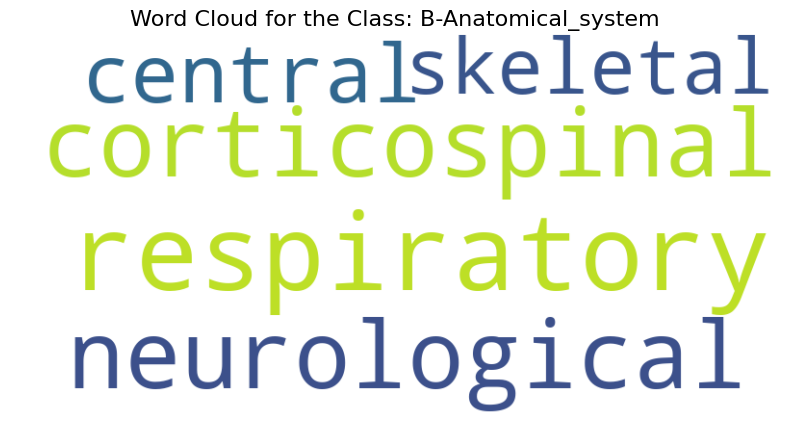

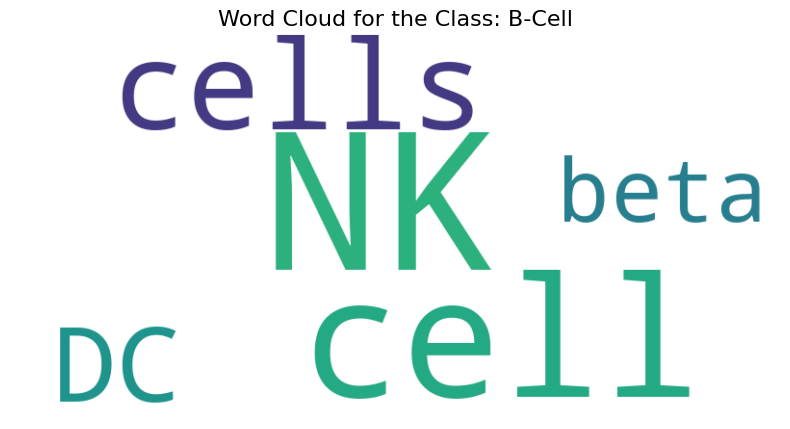

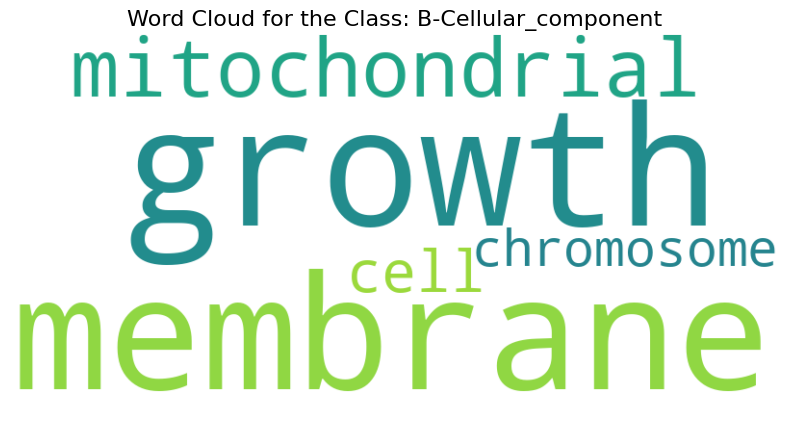

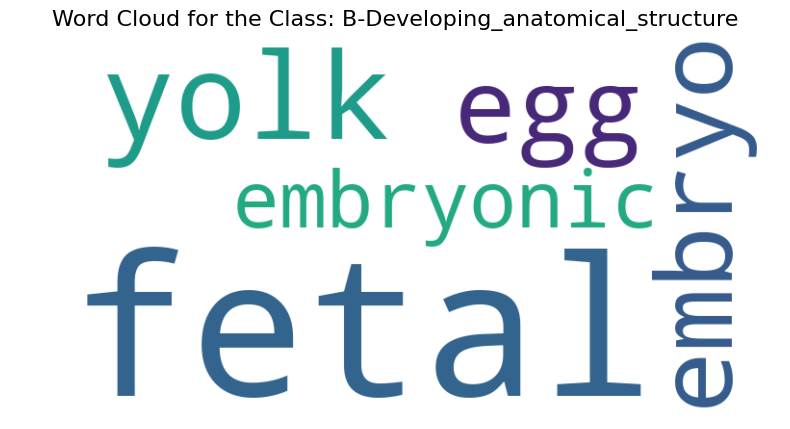

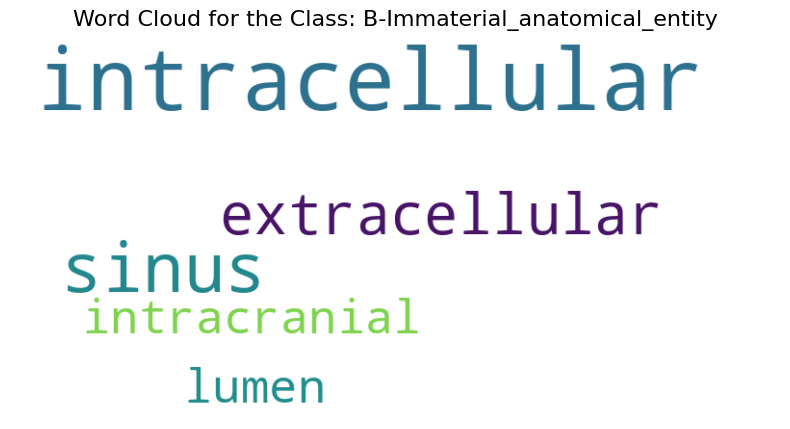

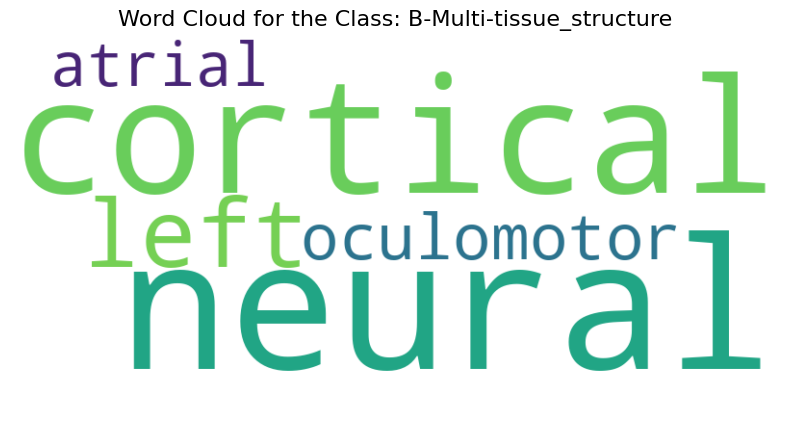

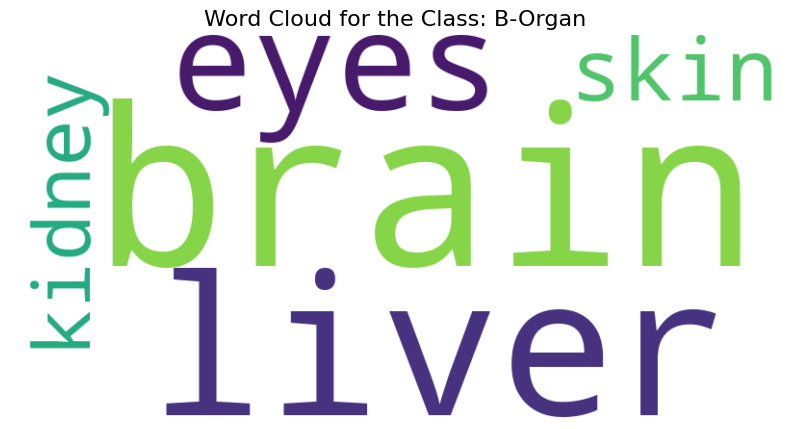

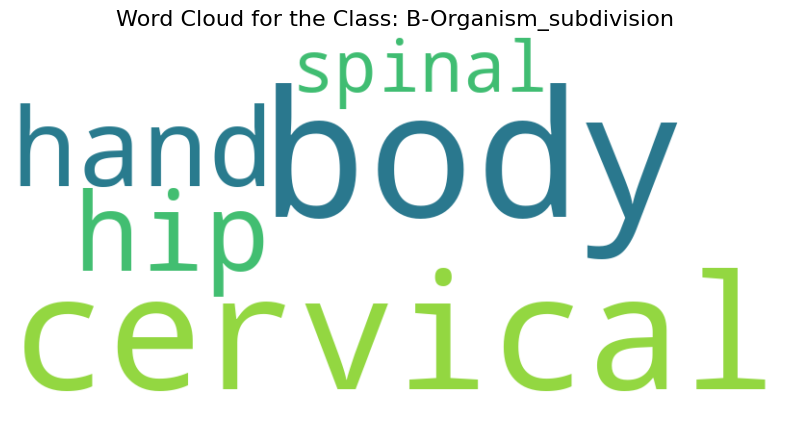

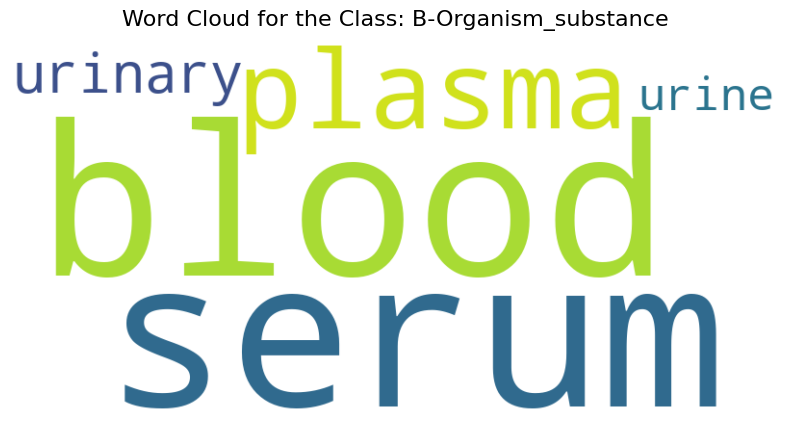

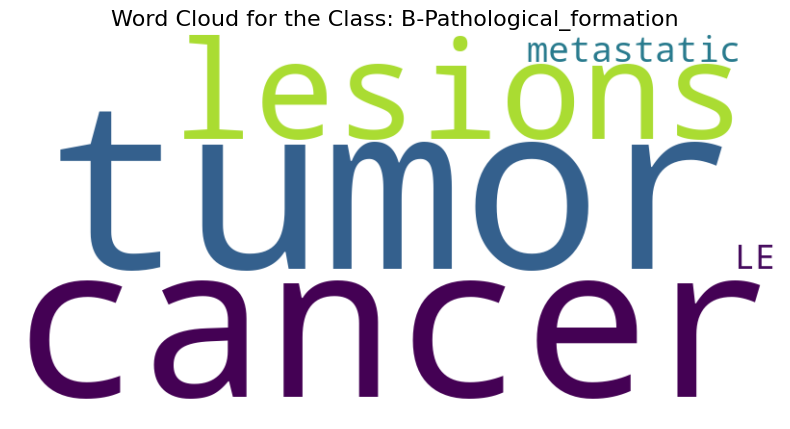

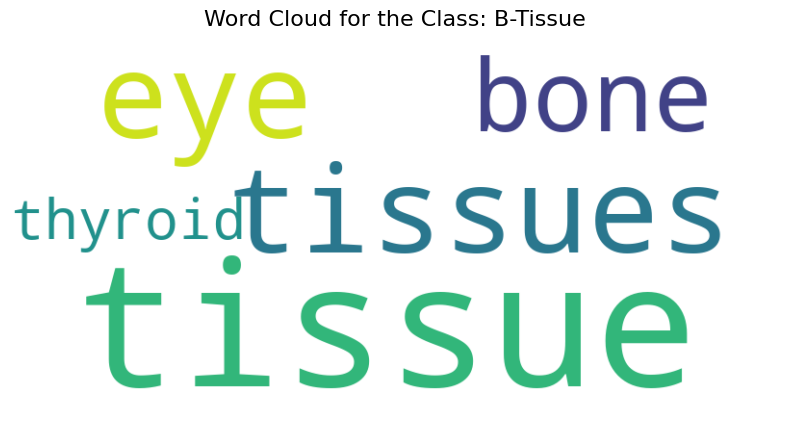

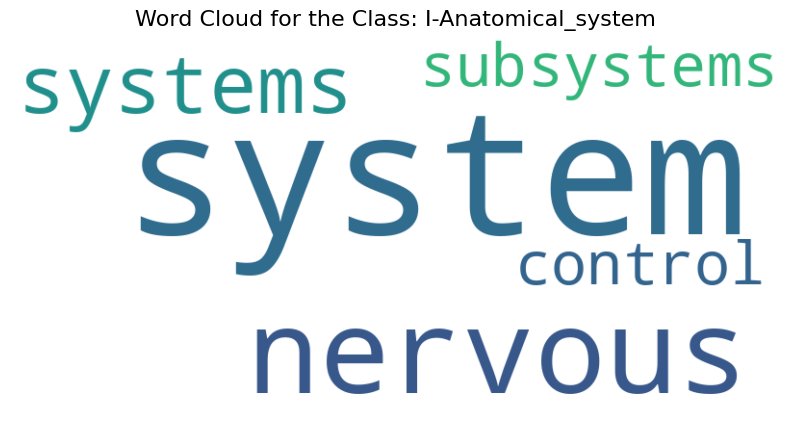

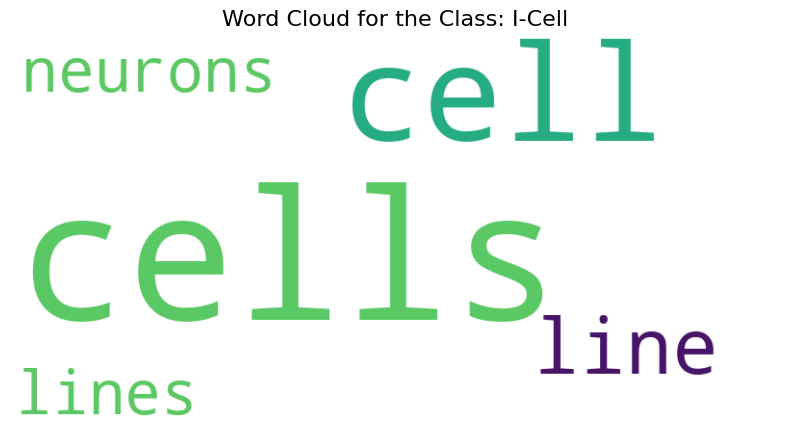

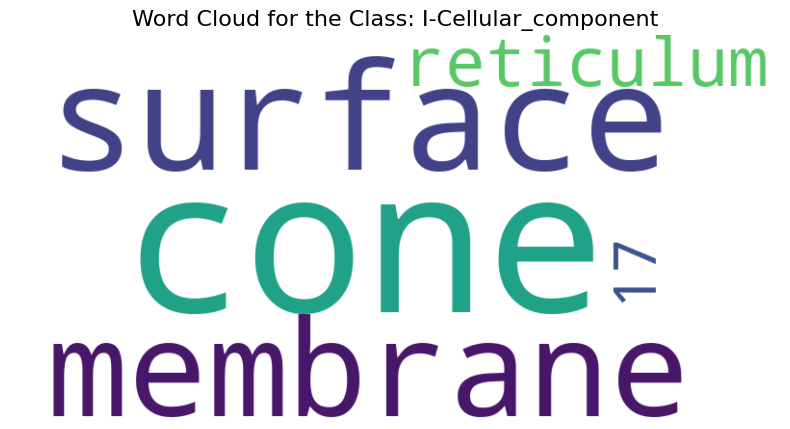

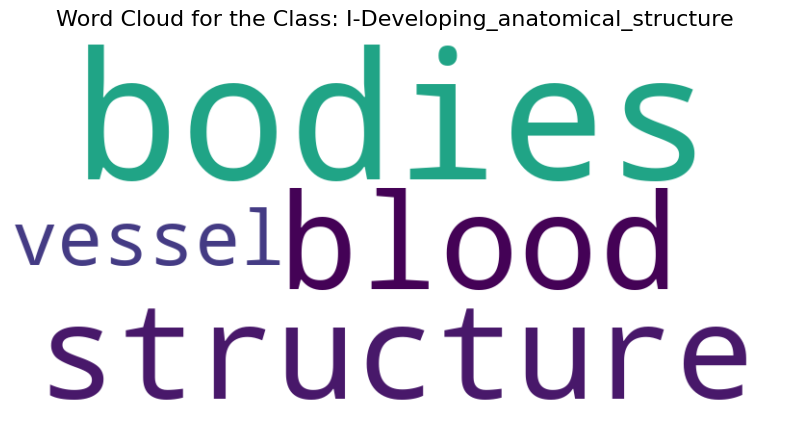

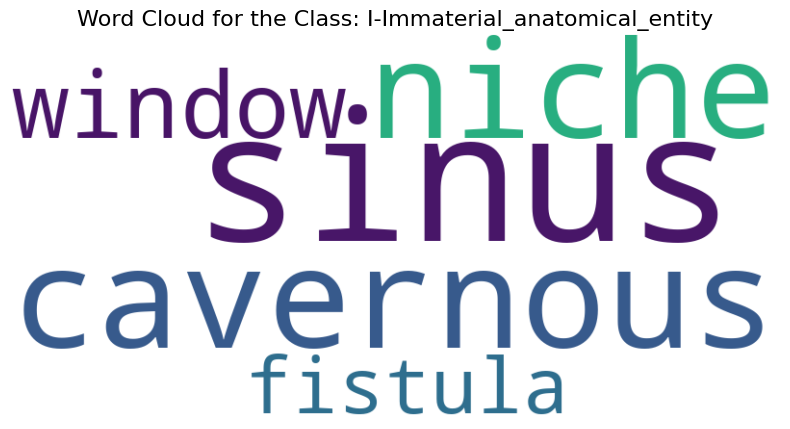

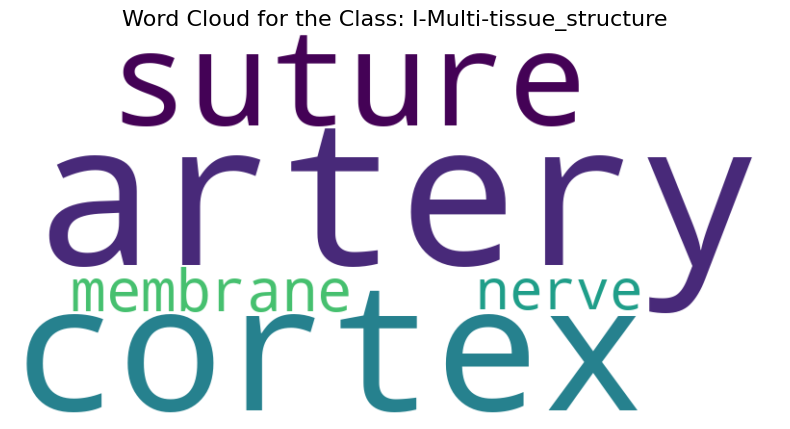

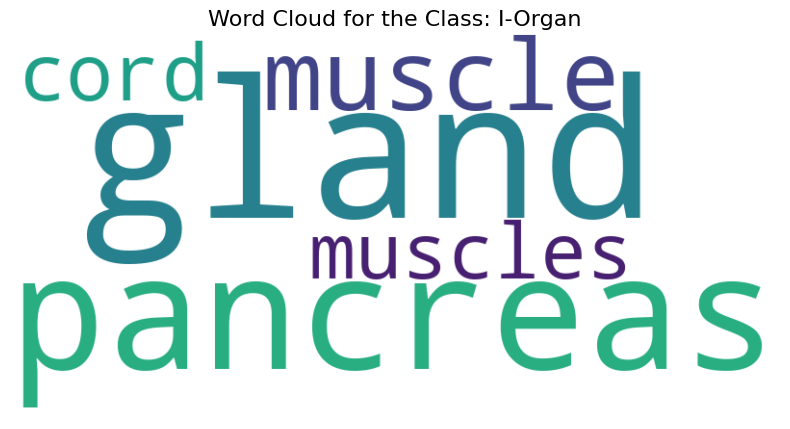

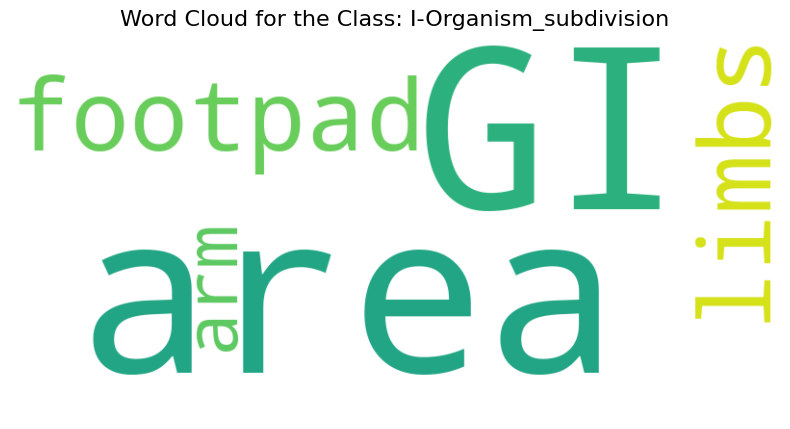

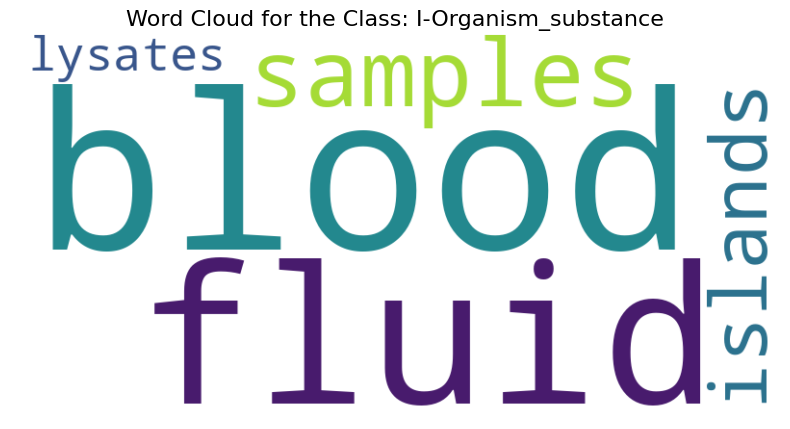

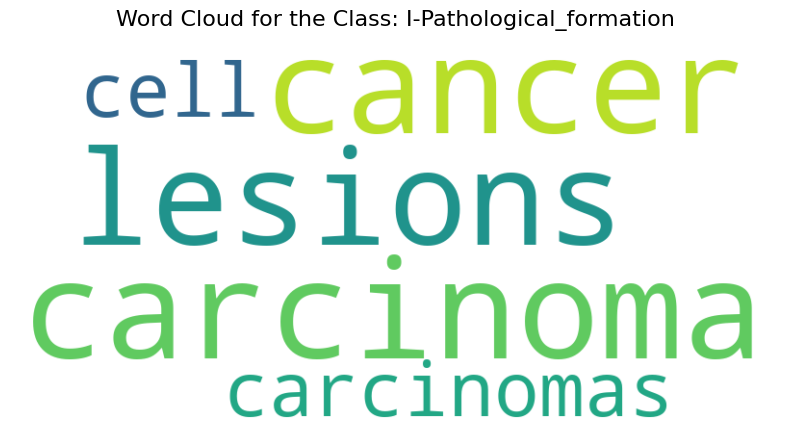

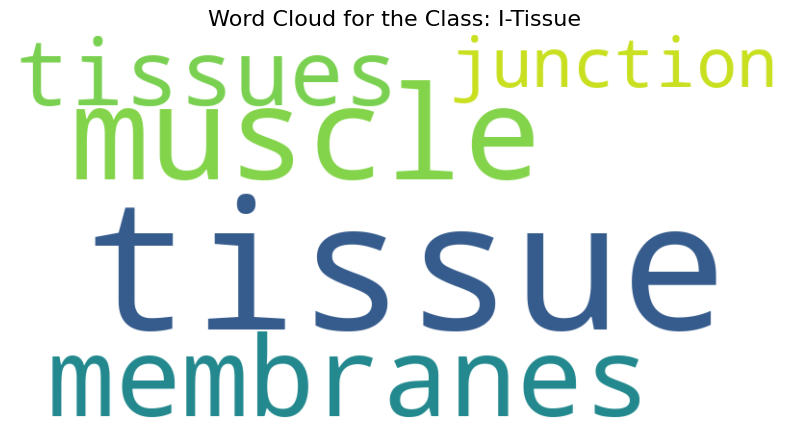

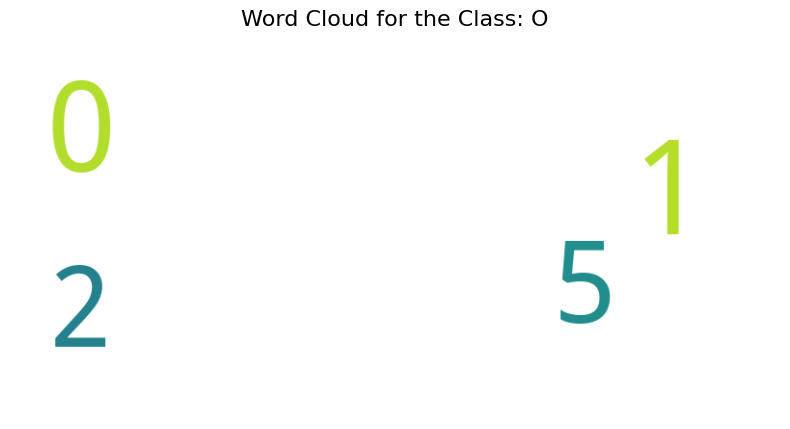

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Funzione per creare la Word Cloud basata sulla frequenza dei token
def create_wordcloud_for_class(frequency_data, class_name):
    # Crea una stringa di testo con i token ripetuti in base alla loro frequenza
    word_freq = dict(frequency_data)

    # Crea la word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(word_freq)

    # Visualizza la Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Disabilita l'asse
    plt.title(f"Word Cloud for the Class: {class_name}", fontsize=16)
    plt.show()


# Ora creiamo la Word Cloud per ciascuna classe
for class_name in most_common_tokens['Label'].unique():
    # Estrai i dati di frequenza per la classe
    class_data = most_common_tokens[most_common_tokens['Label'] == class_name]
    # Crea la Word Cloud per questa classe
    create_wordcloud_for_class(class_data[['id', 'Frequency']].values, class_name)


LDA

In [ ]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models

tokens = ds_cleaned['id'].apply(lambda x: [word.lower() for word in x.split() if word.isalpha() and word.lower() not in nlp.Defaults.stop_words])
# Create a dictionary from the cleaned tokens
dictionary = corpora.Dictionary(tokens)

# Create the corpus (Bag-of-Words format)
corpus = [dictionary.doc2bow(text) for text in tokens]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


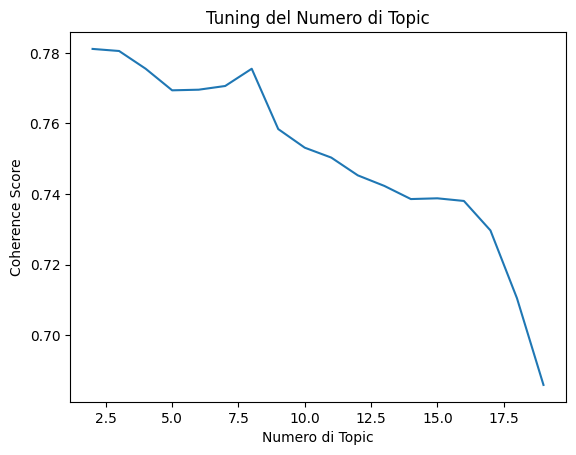

Miglior numero di topic: 2


In [ ]:
# Prova vari numeri di topic
from gensim.models import LdaModel
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

# Specifica il range dei topic
start = 2
limit = 20
step = 1

# Esegui il tuning
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokens, start, limit, step)

# Visualizza i risultati
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Numero di Topic")
plt.ylabel("Coherence Score")
plt.title("Tuning del Numero di Topic")
plt.show()

# Mostra il miglior numero di topic
best_num_topics = x[np.argmax(coherence_values)]
print("Miglior numero di topic:", best_num_topics)


In [ ]:
# Train the LDA model (set the number of topics to 5)
num_topics = best_num_topics
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=15)

# Print the topics discovered
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

# Visualize the topics using pyLDAvis
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.007*"platelet" + 0.006*"cells" + 0.005*"fig" + 0.005*"study" + 0.004*"b" + 0.004*"fetal" + 0.004*"days" + 0.004*"number" + 0.004*"effect" + 0.003*"ephrin"')
(1, '0.008*"data" + 0.008*"cell" + 0.007*"s" + 0.007*"patients" + 0.005*"analysis" + 0.005*"beta" + 0.005*"response" + 0.005*"c" + 0.005*"induced" + 0.005*"expression"')
